# Import libraries

In [2]:
!pip install yfinance

In [3]:
!pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=6cb4c3f17f92550cb24e90c7eab6b6a8e948661701198a50e48f67cbb98cf16f
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta

In [5]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras.utils.vis_utils import plot_model

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [7]:
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix

%matplotlib inline

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

# Loading Data

In [9]:
data = yf.download(tickers ='EURUSD=X', end= '2022-11-11')
# data1 = yf.download(tickers ='JPYUSD=X', start= '2004-06-25', end= '2022-11-13')
# data2 = yf.download(tickers ='GBPUSD=X', start= '2004-06-25', end= '2022-11-13')
#data3 = yf.download(tickers ='AUDUSD=X', start= '2004-06-25', end= '2022-11-13')
#data4 = yf.download(tickers ='USDCHF=X', end= '2022-11-13')
#data.to_csv('USDVND.csv')

[*********************100%***********************]  1 of 1 completed


In [10]:
# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['SMA']= ta.sma(data.Close, length=10)
data['EMA']= ta.ema(data.Close, length= 10)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)
#data['Price Diff ratio'] = data['Adj Close']/data['Adj Close'].shift()
macd = data.ta.macd(fast =12, slow =26, signal =9)
BB = data.ta.bbands(length=12, std =2)
ADX = data.ta.adx(length = 20)
ROC = data.ta.roc(length = 12)
# stochastic = data.ta.stochrsi(length= 14, rsi_length= 3, k=3)
# ST = data.ta.supertrend()
# SAR = data.ta.psar()
# OBV = data.ta.obv()
# Fib = data.ta.fwma(length= 15)
# Pivot = data.ta.
#cycle = data.ta.strategy()
# momentum = data.ta.strategy('Momentum')
# overlap = data.ta.strategy('overlap', length =20)
# performance = data.ta.strategy('performance')
# statistic = data.ta.strategy('statistic')
# trend = data.ta.strategy('trend')
# volatility = data.ta.strategy('volatility')
# data = pd.concat([data, momentum, overlap, performance, statistic, trend, volatility], axis = 1)
data = pd.concat([data, macd, BB, ADX, ROC], axis = 1)
# data.round(2)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4915 entries, 2003-12-01 to 2022-11-10
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           4915 non-null   float64
 1   High           4915 non-null   float64
 2   Low            4915 non-null   float64
 3   Close          4915 non-null   float64
 4   Adj Close      4915 non-null   float64
 5   Volume         4915 non-null   int64  
 6   RSI            4900 non-null   float64
 7   SMA            4906 non-null   float64
 8   EMA            4906 non-null   float64
 9   EMAF           4896 non-null   float64
 10  EMAM           4816 non-null   float64
 11  EMAS           4766 non-null   float64
 12  MACD_12_26_9   4890 non-null   float64
 13  MACDh_12_26_9  4882 non-null   float64
 14  MACDs_12_26_9  4882 non-null   float64
 15  BBL_12_2.0     4904 non-null   float64
 16  BBM_12_2.0     4904 non-null   float64
 17  BBU_12_2.0     4904 non-null   flo

In [12]:
# data['Target'] = data['Adj Close']- data['Adj Close'].shift()
# #data['Target'] = data['Target'].shift(-1)

# data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['returns'] = (data['Adj Close']/data['Adj Close'].shift(1)) -1
data['returnsclass'] = [1 if data.returns[i]>0 else 0 for i in range(len(data))]
#data['TargetNextClose'] = data['Adj Close'].shift(-1)

#data.dropna(inplace=True)
#data.set_index(pd.DatetimeIndex(data[" Date"]), inplace=True)
#data.reset_index(inplace = True)
data.drop(['Volume'], axis=1, inplace=True)

In [13]:
#data.to_csv('TA.csv')

In [14]:
# data.drop(['PVO_12_26_9', 'PVOh_12_26_9', 'PVOs_12_26_9', 'QQEl_14_5_4.236', 'QQEs_14_5_4.236',
#            'SQZ_ON', 'SQZ_OFF', 'SQZ_NO', 'SQZPRO_ON_WIDE', 'SQZPRO_ON_NORMAL', 'SQZPRO_ON_NARROW',
#            'SQZPRO_OFF', 'SQZPRO_NO', 'HILOl_13_21', 'HILOs_13_21', 'SUPERTd_20_3.0', 'SUPERTl_20_3.0',
#            'SUPERTs_20_3.0', 'VWAP_D', 'VWMA_20', 'AMATe_LR_8_21_2', 'AMATe_SR_8_21_2',
#            'DEC_1', 'INC_1', 'PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'PSARr_0.02_0.2', 'TTM_TRND_6',
#            'THERMOl_20_2_0.5', 'THERMOs_20_2_0.5'], axis=1, inplace=True)

In [15]:
data.dropna(inplace=True)

In [16]:
data_set = data.iloc[:, ]#.values
#pd.set_option('display.max_columns', None)

data_set.head(5)
#print(data_set.shape)
#print(data.shape)
#print(type(data_set))
#data_set.to_csv('EURUSDTA.csv')

,Open,High,Low,Close,Adj Close,RSI,SMA,EMA,EMAF,EMAM,...,BBM_12_2.0,BBU_12_2.0,BBB_12_2.0,BBP_12_2.0,ADX_20,DMP_20,DMN_20,ROC_12,returns,returnsclass
Date,,,,,,,,,,,,,,,,,,,,,
2004-06-25,1.217093,1.220301,1.211299,1.220301,1.220301,54.911255,1.211252,1.213470,1.212295,1.219270,...,1.210410,1.222711,2.032554,0.902022,10.529251,19.865586,19.370648,1.328905,0.002380,1
2004-06-28,1.217493,1.222703,1.212797,1.218695,1.218695,53.966191,1.212501,1.214420,1.212905,1.219258,...,1.211060,1.224191,2.168541,0.790725,10.197999,20.052943,18.542993,0.643457,-0.001316,0
2004-06-29,1.218695,1.219096,1.207496,1.209804,1.209804,48.968246,1.211821,1.213581,1.212610,1.219071,...,1.211751,1.223609,1.957117,0.417904,9.797026,19.049638,19.901794,0.690796,-0.007295,0
2004-06-30,1.209497,1.220301,1.206797,1.218398,1.218398,53.434557,1.213591,1.214457,1.213161,1.219058,...,1.212768,1.224639,1.957702,0.737134,9.345300,18.464605,18.752050,1.011273,0.007103,1
2004-07-01,1.218294,1.220807,1.213902,1.216205,1.216205,52.185715,1.214872,1.214775,1.213451,1.219001,...,1.212734,1.224565,1.950986,0.646672,8.885485,18.128930,18.186492,-0.032835,-0.001800,0


In [17]:
data_set=data_set.drop(data_set.index[0:2445]) #matching dataset with Sentiment analysis

In [18]:
data_set.head()

,Open,High,Low,Close,Adj Close,RSI,SMA,EMA,EMAF,EMAM,...,BBM_12_2.0,BBU_12_2.0,BBB_12_2.0,BBP_12_2.0,ADX_20,DMP_20,DMN_20,ROC_12,returns,returnsclass
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-16,1.373815,1.379900,1.373815,1.373928,1.373928,61.180787,1.368764,1.369946,1.364524,1.347592,...,1.367213,1.383660,2.405920,0.704164,15.357994,22.396920,14.854837,1.220049,-0.000838,0
2013-12-17,1.376178,1.378210,1.372701,1.376292,1.376292,62.811095,1.370973,1.371100,1.365645,1.348160,...,1.368537,1.385135,2.425581,0.733614,15.493713,21.662505,15.031101,1.168472,0.001720,1
2013-12-18,1.377107,1.378099,1.373479,1.377126,1.377126,63.392301,1.372779,1.372196,1.366738,1.348734,...,1.370088,1.386118,2.339867,0.719524,15.622646,21.053065,14.608225,1.370242,0.000606,1
2013-12-19,1.368307,1.369394,1.365113,1.368495,1.368495,54.028961,1.373764,1.371523,1.366905,1.349125,...,1.371279,1.384242,1.890574,0.392590,14.973438,19.547899,18.542880,1.055106,-0.006268,0
2013-12-20,1.365598,1.370870,1.362583,1.365579,1.365579,51.287513,1.373623,1.370442,1.366779,1.349451,...,1.371822,1.383133,1.649117,0.224048,14.297832,18.583230,19.134403,0.479314,-0.002130,0


In [19]:
data_set.shape

(2321, 25)

In [20]:
data_set_count = data_set[['Close','returnsclass']].copy()
data_set_count = data_set_count.groupby('returnsclass').count()
data_set_count =data_set_count.rename(columns={'Close':'Count'})
data_set_count

,Count
returnsclass,
0,1186
1,1135


In [21]:
data_set.drop(['returns'], axis=1, inplace=True)

# DATA VISUALIZATION

In [54]:
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
#copy the dataset
df1_copy = data_set[['Adj Close','RSI']].copy()
df2_copy = data_set[['Adj Close','SMA','EMA']].copy()
df3_copy = data_set[['Adj Close','MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9']].copy()
df4_copy = data_set[['Adj Close','BBL_12_2.0','BBM_12_2.0',	'BBU_12_2.0']].copy()
df5_copy = data_set[['Adj Close','ADX_20']].copy()
df6_copy = data_set[['Adj Close','ROC_12']].copy()
df7_copy = data[['Adj Close','returns']].copy()

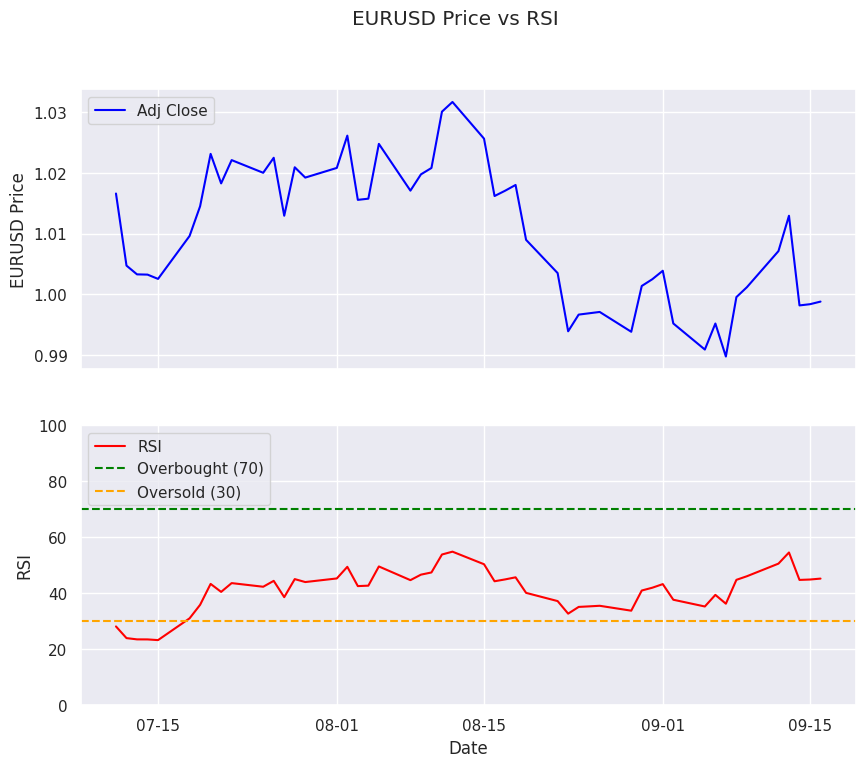

In [26]:
# Relative Strength Index (RSI)

# Filter the data for the desired date range
start_date = '2022-07-11'
end_date = '2022-09-16'
filtered_data1 = df1_copy.loc[start_date:end_date]
# Extract the necessary columns
adj_close = filtered_data1['Adj Close']
rsi = filtered_data1['RSI']

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Adj Close
ax1.plot(adj_close.index, adj_close, color='blue', label='Adj Close')
ax1.set_ylabel('EURUSD Price')

# Plot RSI
ax2.plot(rsi.index, rsi, color='red', label='RSI')
ax2.set_ylabel('RSI')
ax2.set_ylim(0, 100)

# Add horizontal lines at y=70 and y=30
ax2.axhline(y=70, color='green', linestyle='--', label='Overbought (70)')
ax2.axhline(y=30, color='orange', linestyle='--', label='Oversold (30)')

# Customize the plot
fig.suptitle('EURUSD Price vs RSI')
ax2.set_xlabel('Date')

# Format x-axis labels as month and day
date_formatter = mdates.DateFormatter('%m-%d')
ax2.xaxis.set_major_formatter(date_formatter)

# Set the x-axis tick frequency
# ax2.xaxis.set_major_locator(mdates.MonthLocator())

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

# Show the plot
plt.show()

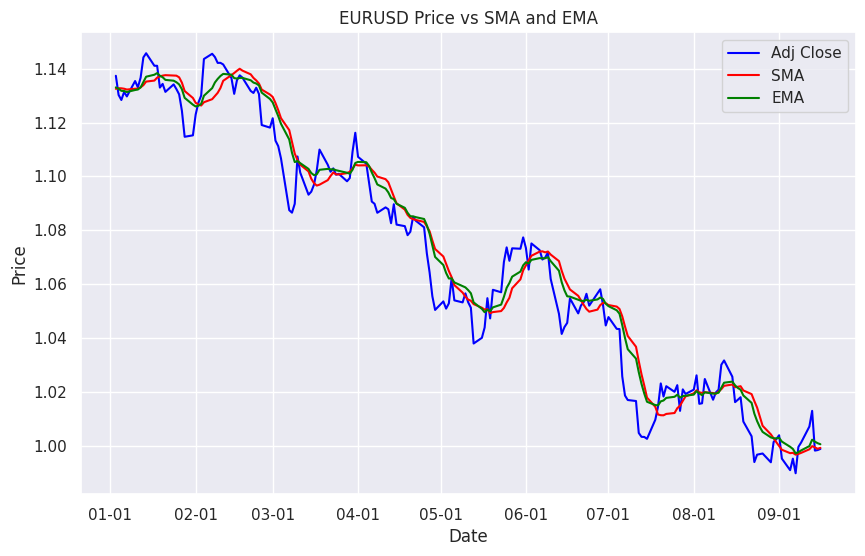

In [24]:
# Price vs SMA and EMA

# Filter the data for the desired date range
start_date = '2022-01-03'
end_date = '2022-09-16'
filtered_data2 = df2_copy.loc[start_date:end_date]

# Extract the necessary columns from the filtered data
adj_close = filtered_data2['Adj Close']
sma = filtered_data2['SMA']
ema = filtered_data2['EMA']

# Create the figure and axis
fig1, ax = plt.subplots(figsize=(10, 6))

# Plot the price
ax.plot(adj_close.index, adj_close, color='blue', label='Adj Close')

# Plot the SMA
ax.plot(sma.index, sma, color='red', label='SMA')

# Plot the EMA
ax.plot(ema.index, ema, color='green', label='EMA')

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('EURUSD Price vs SMA and EMA')

# Format x-axis labels as month and date
date_formatter = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(date_formatter)

# Set the x-axis tick frequency
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Add a legend
ax.legend()

# Show the plot
plt.show()

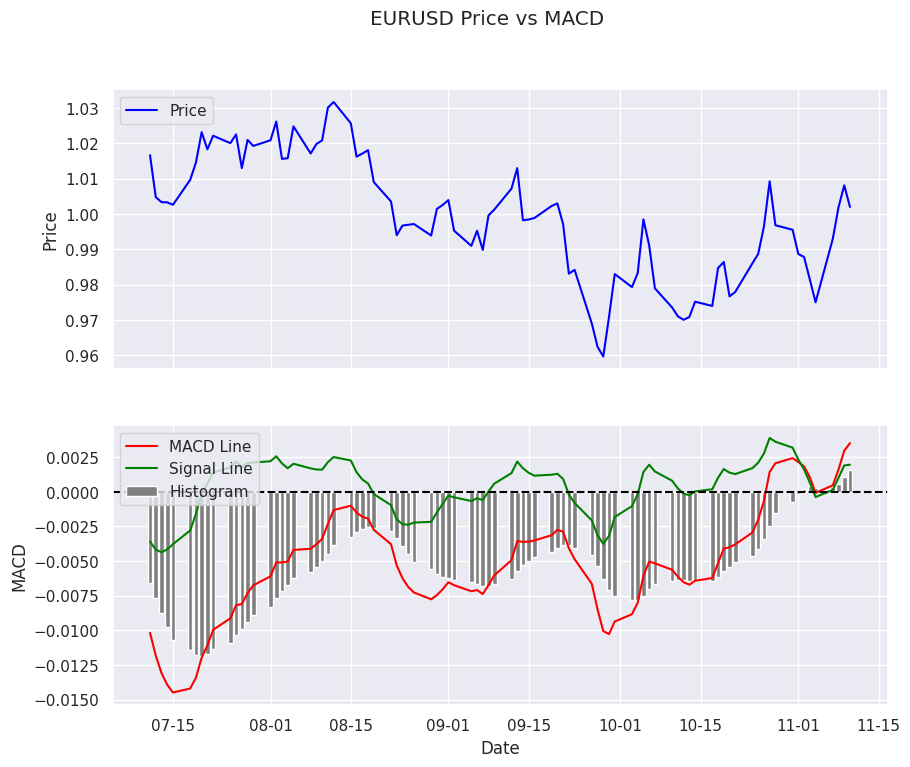

In [31]:
# Price vs MACD

# Filter the data for the desired date range
start_date = '2022-07-11'
end_date = '2022-11-10'
filtered_data3 = df3_copy.loc[start_date:end_date]

# Extract the necessary columns from the filtered data
adj_close = filtered_data3['Adj Close']
macd_line = filtered_data3['MACD_12_26_9']
signal_line = filtered_data3['MACDh_12_26_9']
histogram = filtered_data3['MACDs_12_26_9']

# Create the figure and subplots
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot the price chart
ax3.plot(adj_close.index, adj_close, color='blue', label='Price')
ax3.set_ylabel('Price')

# Plot MACD and signal line
ax4.plot(macd_line.index, macd_line, color='red', label='MACD Line')
ax4.plot(signal_line.index, signal_line, color='green', label='Signal Line')
ax4.set_ylabel('MACD')

# Plot the histogram
ax4.bar(histogram.index, histogram, color='gray', label='Histogram')

# Add horizontal line at y=0 for the histogram
ax4.axhline(y=0, color='black', linestyle='--')

# Add legend to both subplots
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

# Format x-axis labels as month and date
date_formatter = mdates.DateFormatter('%m-%d')
ax4.xaxis.set_major_formatter(date_formatter)

# Set the x-axis tick frequency
# ax4.xaxis.set_major_locator(mdates.MonthLocator())

# Set x-axis label
fig2.suptitle('EURUSD Price vs MACD')
plt.xlabel('Date')

# Show the plot
plt.show()

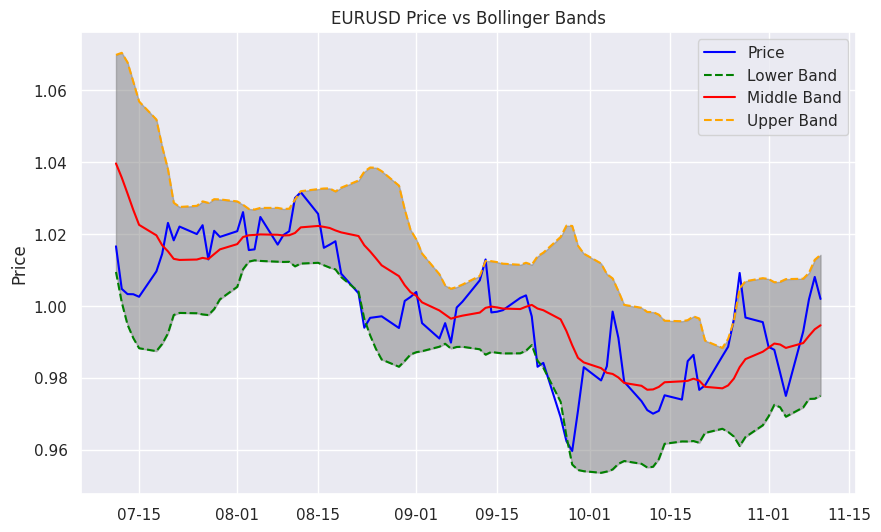

In [34]:
# Price vs Bollinger Bands

# Filter the data for the desired date range
start_date = '2022-07-11'
end_date = '2022-11-10'
filtered_data4 = df4_copy.loc[start_date:end_date]

# Extract the necessary columns from the filtered data
price = filtered_data4['Adj Close']
lower_band = filtered_data4['BBL_12_2.0']
middle_band = filtered_data4['BBM_12_2.0']
upper_band = filtered_data4['BBU_12_2.0']

# Create the figure and axis
fig3, ax5 = plt.subplots(figsize=(10, 6))

# Plot the price
ax5.plot(price.index, price, color='blue', label='Price')

# Plot the Bollinger Bands
ax5.plot(lower_band.index, lower_band, color='green', linestyle='--', label='Lower Band')
ax5.plot(middle_band.index, middle_band, color='red', label='Middle Band')
ax5.plot(upper_band.index, upper_band, color='orange', linestyle='--', label='Upper Band')

# Highlight the region between the lower and upper bands
ax5.fill_between(price.index, lower_band, upper_band, color='grey', alpha=0.5)

# Add labels and title
ax5.set_ylabel('Price')
ax5.set_title('EURUSD Price vs Bollinger Bands')

# Format x-axis labels as month and date
date_formatter = mdates.DateFormatter('%m-%d')
ax5.xaxis.set_major_formatter(date_formatter)

# Set the x-axis tick frequency
# ax5.xaxis.set_major_locator(mdates.MonthLocator())

# Add legend
ax5.legend()

# Show the plot
plt.show()

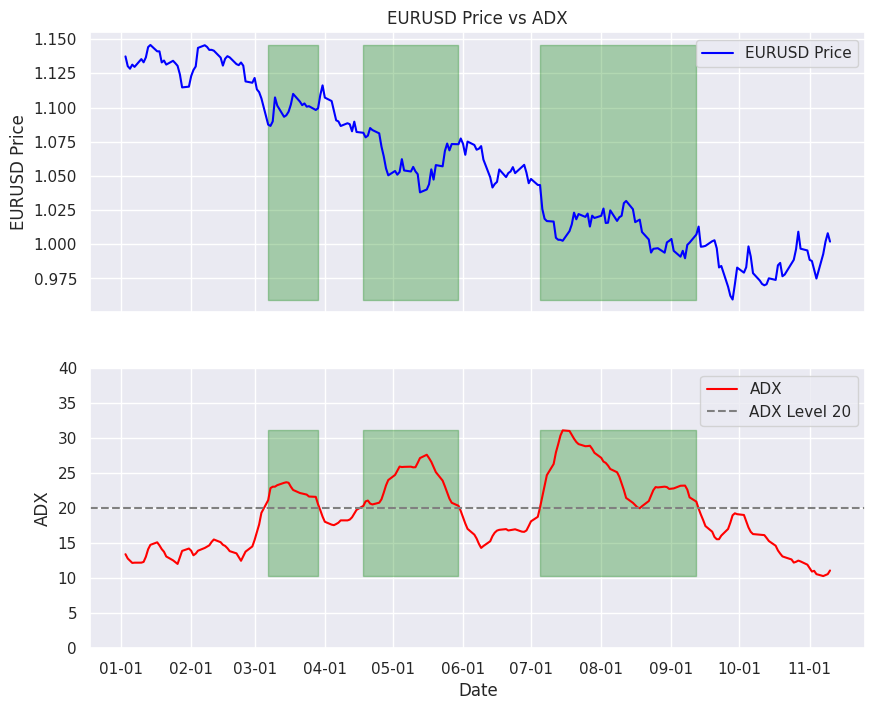

In [58]:
# Price vs ADX

# Filter the data for the desired date range
start_date = '2022-01-01'
end_date = '2022-11-10'
filtered_data5 = df5_copy.loc[start_date:end_date]

# Extract the necessary columns from the filtered data
price = filtered_data5['Adj Close']
adx = filtered_data5['ADX_20']

# Create the figure and subplots
fig4, (ax6, ax7) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot EURUSD Price
ax6.plot(price.index, price, color='blue', label='EURUSD Price')
ax6.set_ylabel('EURUSD Price')

# Set the y-axis range for ADX
ax7.set_ylim(0, 40)

# Plot ADX
ax7.plot(adx.index, adx, color='red', label='ADX')
ax7.set_ylabel('ADX')

# Add a horizontal line at ADX level 20
ax7.axhline(y=20, color='gray', linestyle='--', label='ADX Level 20')

# Highlight the corresponding EURUSD prices when ADX is between 20 and 35
highlight_color = 'green'
ax6.fill_between(price.index, price.min(), price.max(), where=((adx >= 20) & (adx <= 35)), color=highlight_color, alpha=0.3)

# Highlight the corresponding ADX values when ADX is between 20 and 35
ax7.fill_between(adx.index, adx.min(), adx.max(), where=((adx >= 20) & (adx <= 35)), color=highlight_color, alpha=0.3)

# Add labels and title
ax7.set_xlabel('Date')
ax6.set_title('EURUSD Price vs ADX')

# Format x-axis labels as month and date
date_formatter = mdates.DateFormatter('%m-%d')
ax7.xaxis.set_major_formatter(date_formatter)

# Set the x-axis tick frequency
ax7.xaxis.set_major_locator(mdates.MonthLocator())

# Add legend
ax6.legend()
ax7.legend()

# Show the plot
plt.show()

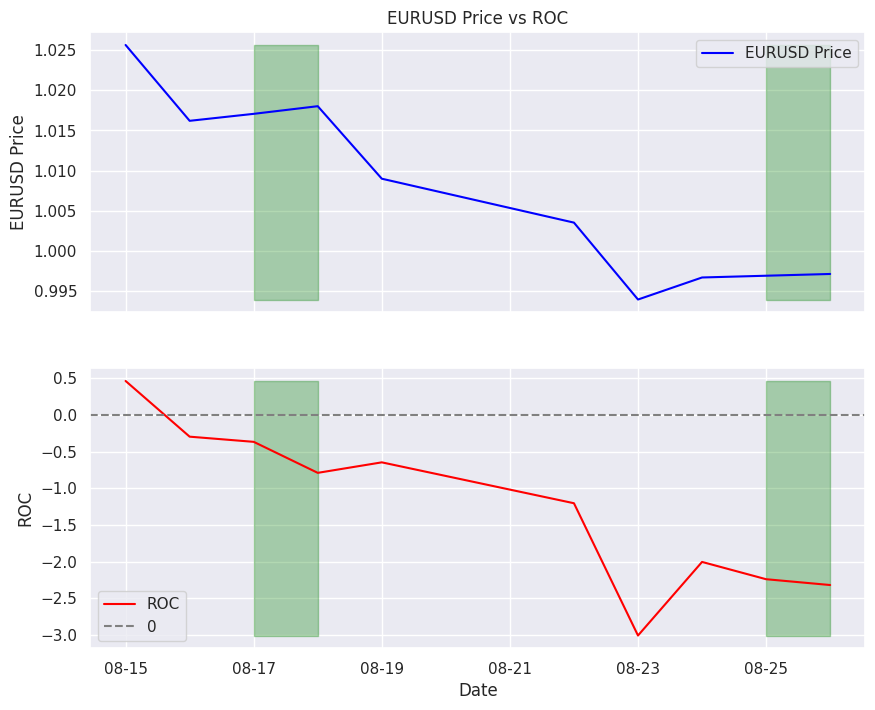

In [61]:
# Price vs ROC

# Filter the data for the desired date range
start_date = '2022-08-15'
end_date = '2022-08-27'
filtered_data6 = df6_copy.loc[start_date:end_date]

# Extract the necessary columns from the filtered data
price = filtered_data6['Adj Close']
roc = filtered_data6['ROC_12']

# Create the figure and subplots
fig5, (ax8, ax9) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot EURUSD Price
ax8.plot(price.index, price, color='blue', label='EURUSD Price')
ax8.set_ylabel('EURUSD Price')

# Plot ROC
ax9.plot(roc.index, roc, color='red', label='ROC')
ax9.set_ylabel('ROC')

# Add a horizontal line at the 0 level for ROC
ax9.axhline(y=0, color='gray', linestyle='--', label='0')

# Highlight the price where price is increasing but ROC is decreasing
highlight_color = 'green'
ax8.fill_between(price.index, price.min(), price.max(), where=((price.diff() > 0) & (roc.diff() < 0)), color=highlight_color, alpha=0.3)
ax9.fill_between(roc.index, roc.min(), roc.max(), where=((price.diff() > 0) & (roc.diff() < 0)), color=highlight_color, alpha=0.3)

# Add labels and title
ax9.set_xlabel('Date')
ax8.set_title('EURUSD Price vs ROC')

# Format x-axis labels as month and date
date_formatter = mdates.DateFormatter('%m-%d')
ax9.xaxis.set_major_formatter(date_formatter)

# Set the x-axis tick frequency
# ax9.xaxis.set_major_locator(mdates.MonthLocator())

# Add legend
ax8.legend()
ax9.legend()

# Show the plot
plt.show()

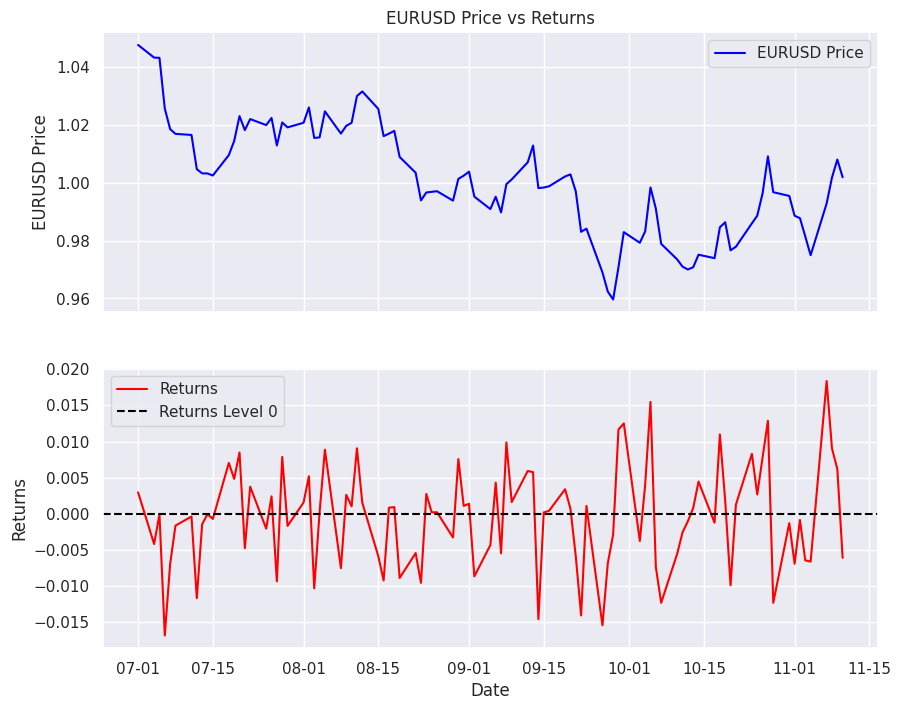

In [57]:
# Price vs Returns

# Filter the data for the desired date range
start_date = '2022-07-01'
end_date = '2022-11-10'
filtered_data7 = df7_copy.loc[start_date:end_date]

# Extract the necessary columns from the filtered data
price = filtered_data7['Adj Close']
returns = filtered_data7['returns']

# Create the figure and subplots
fig6, (ax10, ax11) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot EURUSD Price
ax10.plot(price.index, price, color='blue', label='EURUSD Price')
ax10.set_ylabel('EURUSD Price')

# Plot Returns
ax11.plot(returns.index, returns, color='red', label='Returns')
ax11.set_ylabel('Returns')

# Add a horizontal line at 0 for Returns
ax11.axhline(y=0, color='black', linestyle='--', label='Returns Level 0')

# Add labels and title
ax11.set_xlabel('Date')
ax10.set_title('EURUSD Price vs Returns')

# Format x-axis labels as month and date
date_formatter = mdates.DateFormatter('%m-%d')
ax11.xaxis.set_major_formatter(date_formatter)

# Set the x-axis tick frequency
# ax11.xaxis.set_major_locator(mdates.MonthLocator())

# Add legend
ax10.legend()
ax11.legend()

# Show the plot
plt.show()

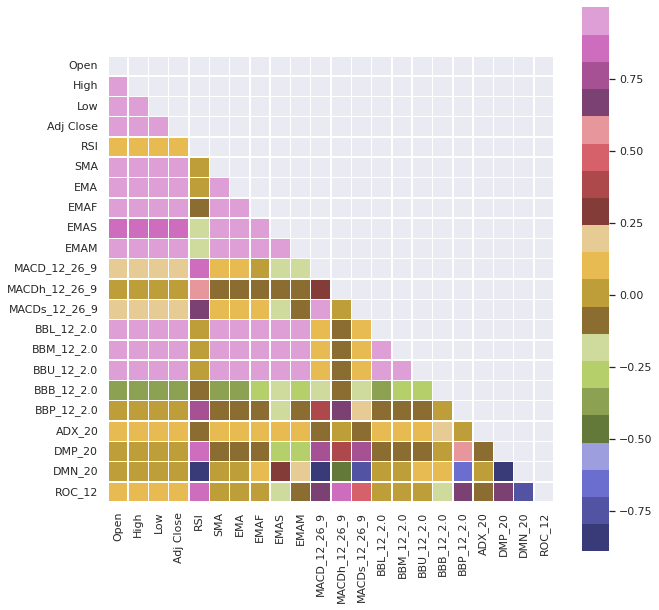

In [ ]:
#First, prepare the data to be graphed:
columnname = ['Open','High','Low','Adj Close', 'RSI', 'SMA','EMA', 'EMAF', 'EMAS', 'EMAM',
              'MACD_12_26_9',	'MACDh_12_26_9',	'MACDs_12_26_9',	'BBL_12_2.0',
              'BBM_12_2.0',	'BBU_12_2.0',	'BBB_12_2.0',	'BBP_12_2.0',	'ADX_20',	'DMP_20',	'DMN_20',	'ROC_12']
#'stoch100', 'rsi60', 'momentum20'
dfgraph = data_set[columnname]

#Then, graph the data:
corr = dfgraph.corr()

#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap = "tab20b", mask = mask, square = True, linewidths = 0.5)

In [ ]:
#montly return from different currencies
month_EURUSD = data_set[['returns']].copy()
month_EURUSD['month'] = month_EURUSD.index.astype(str).str[:7]
month_EURUSD = month_EURUSD.groupby('month').sum().reset_index(drop=True)

# data1['month'] = data1.index.astype(str).str[:7]
# month_JPYUSD = data1.groupby('month').sum().reset_index()
# month_JPYUSD = month_JPYUSD[['month', 'returns']].copy()

# data2['month'] = data2.index.astype(str).str[:7]
# month_GBPUSD = data2.groupby('month').sum().reset_index()
# month_GBPUSD = month_GBPUSD[['month', 'returns']].copy()

# # data3['month'] = data3.index.astype(str).str[:7]
# # month_AUDUSD = data3.groupby('month').sum().reset_index()
# # month_AUDUSD = month_AUDUSD[['month', 'returns']].copy()

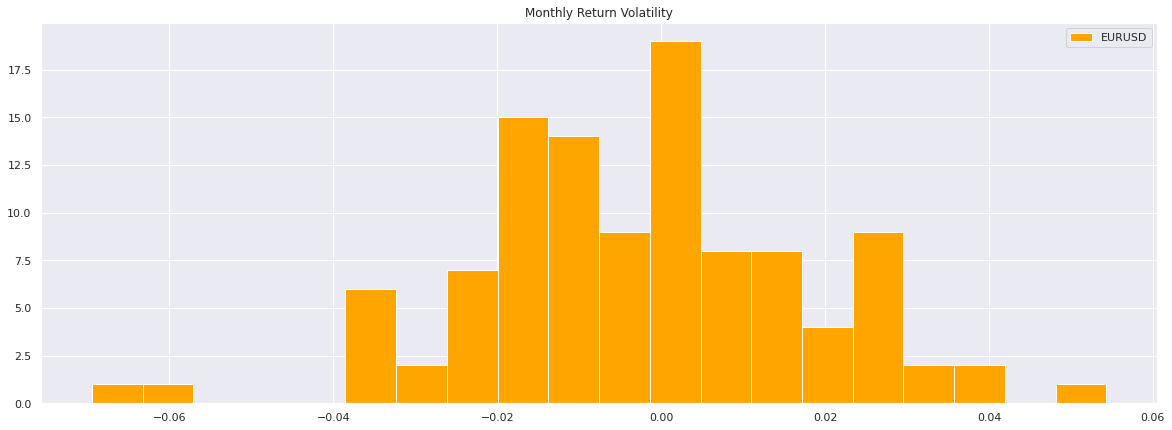

In [ ]:
month_EURUSD['returns'].hist(bins = 20, label = 'EURUSD', alpha = 1, figsize = (20,7), color = 'orange')
#month_JPYUSD['returns'].hist(bins = 20, label = 'JPYUSD', alpha = 0.3, color ='b')
#month_GBPUSD['returns'].hist(bins = 10, label = 'GBPUSD', alpha = 0.4, color='g')
#month_AUDUSD['returns'].hist(bins = 7, label = 'AUDUSD', alpha = 0.3, color='purple')
plt.title('Monthly Return Volatility')
plt.legend()
#explaining: https://www.initialreturn.com/creating-a-histogram-of-stock-returns-with-excel/
# EURUSD made more loss, EUR is weaker against USD

# STACKED LSTM MODEL

### DATA PROCESSING

In [ ]:
# Separate the features (historical prices and technical indicators) and the target (movement)
features = data_set.iloc[:, :-1]
target = data_set['returnsclass'].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
scaled_features.shape

(2321, 23)

In [ ]:
scaled_target.shape

(2321, 1)

In [ ]:
# Reshape the input data for LSTM (samples, time steps, features)
lookback = 14  # Number of previous time steps to consider
num_features = 23
num_samples = scaled_features.shape[0]

In [ ]:
num_sequences = num_samples - lookback + 1

In [ ]:
num_sequences

2308

In [ ]:
X = np.zeros((num_sequences, lookback, num_features))

for i in range(num_sequences):
    X[i] = scaled_features[i : i + lookback]
print(X.shape)

(2308, 14, 23)


In [ ]:
y = scaled_target[lookback-1:lookback-1+num_sequences]
y = np.reshape(y, (y.shape[0], 1))
print(y.shape)

(2308, 1)


In [ ]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print (X_train.shape)
print (y_train.shape)

(1846, 14, 23)
(1846, 1)


### MODEL

In [ ]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(lookback, X_train.shape[2])))
model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=75))
# model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 150)           104400    
                                                                 
 dropout (Dropout)           (None, 14, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 75)                67800     
                                                                 
 dense (Dense)               (None, 1)                 76        
                                                                 
Total params: 172,276
Trainable params: 172,276
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history= model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split = 0.2)

Epoch 1/40
47/47 [==============================] - 11s 88ms/step - loss: 0.6958 - accuracy: 0.5054 - val_loss: 0.6924 - val_accuracy: 0.5243
Epoch 2/40
47/47 [==============================] - 3s 59ms/step - loss: 0.6932 - accuracy: 0.5237 - val_loss: 0.6917 - val_accuracy: 0.5324
Epoch 3/40
47/47 [==============================] - 4s 77ms/step - loss: 0.6932 - accuracy: 0.5169 - val_loss: 0.6904 - val_accuracy: 0.5243
Epoch 4/40
47/47 [==============================] - 3s 70ms/step - loss: 0.6911 - accuracy: 0.5196 - val_loss: 0.6896 - val_accuracy: 0.5324
Epoch 5/40
47/47 [==============================] - 3s 58ms/step - loss: 0.6904 - accuracy: 0.5230 - val_loss: 0.6876 - val_accuracy: 0.5595
Epoch 6/40
47/47 [==============================] - 2s 33ms/step - loss: 0.6851 - accuracy: 0.5535 - val_loss: 0.6828 - val_accuracy: 0.5216
Epoch 7/40
47/47 [==============================] - 1s 30ms/step - loss: 0.6526 - accuracy: 0.6301 - val_loss: 0.6045 - val_accuracy: 0.6297
Epoch 8/40
4

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

15/15 [==============================] - 0s 9ms/step - loss: 0.1222 - accuracy: 0.9481
Test Loss: 0.12224921584129333
Test Accuracy: 0.948051929473877


In [ ]:
predictions = model.predict(X_test)

15/15 [==============================] - 1s 10ms/step


In [ ]:
threshold = 0.5  # Threshold to convert probabilities to binary labels

incorrect_predictions = []

# Convert predicted probabilities to binary labels
binary_predictions = np.where(predictions > threshold, 1, 0)

for true_label, predicted_label in zip(y_test, binary_predictions):
    if true_label != predicted_label:
        incorrect_predictions.append((true_label, predicted_label))

incorrect_predictions_count = len(incorrect_predictions)
print(f"Number of Incorrect Predictions: {incorrect_predictions_count}")

Number of Incorrect Predictions: 24


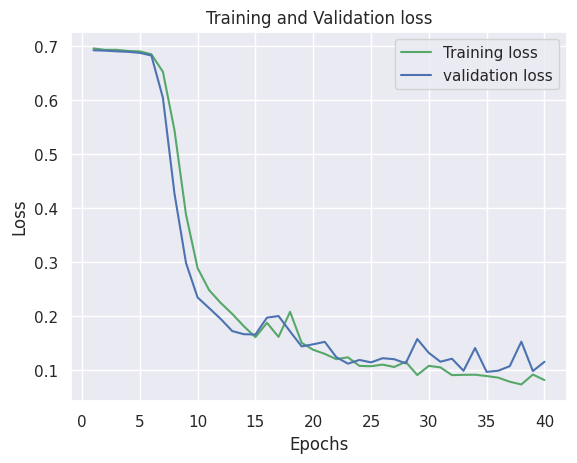

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

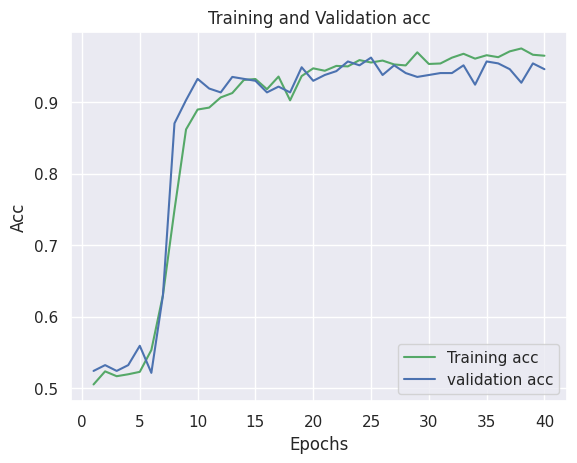

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,41)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.plot(epochs, acc_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert predicted probabilities to binary labels
binary_predictions = np.where(predictions > threshold, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions, digits=4))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, binary_predictions))

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9685    0.9267    0.9471       232
         1.0     0.9292    0.9696    0.9489       230

    accuracy                         0.9481       462
   macro avg     0.9488    0.9481    0.9480       462
weighted avg     0.9489    0.9481    0.9480       462

Confusion Matrix:
[[215  17]
 [  7 223]]


### NEXT DAY PREDICTION

In [ ]:
# Prepare the input data for prediction (assuming X_test represents the most recent data available)
input_data = scaled_features[-lookback:]  # Select the most recent lookback period as input data

# Reshape the input data
input_data = np.reshape(input_data, (1, lookback, num_features))  # Adjust the shape based on your specific lookback and feature dimensions

# Make the prediction
prediction = model.predict(input_data)

# Interpret the prediction
if prediction > 0.5:
    price_movement = "Positive"
else:
    price_movement = "Negative"

# Print the predicted price movement
print("Next day's price movement:", price_movement)

1/1 [==============================] - 0s 18ms/step
Next day's price movement: Negative


# SINGLE LSTM MODEL

## Data preprocessing for LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)
print(data_set_scaled[0].size)

[[0.95575293 0.95554347 0.96010293 ... 0.65249573 0.47806662 0.        ]
 [0.96120628 0.95163066 0.95755404 ... 0.64874876 0.5235121  1.        ]
 [0.96334911 0.95137574 0.95933491 ... 0.66340681 0.50371678 1.        ]
 ...
 [0.09747834 0.09815244 0.09969114 ... 0.74196134 0.65365144 1.        ]
 [0.11183391 0.09690325 0.10802951 ... 0.7265157  0.60325611 1.        ]
 [0.09768685 0.11870528 0.09093904 ... 0.66161841 0.38492282 0.        ]]
25


In [ ]:
# multiple feature from data provided to the model
X = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 14
print(data_set_scaled.shape[0])
for j in range(23):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

2321


In [ ]:
#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

In [ ]:
#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

[[[0.95575293 0.95554347 0.96010293 ... 0.54253366 0.29084473 0.65249573]
  [0.96120628 0.95163066 0.95755404 ... 0.51841105 0.29642531 0.64874876]
  [0.96334911 0.95137574 0.95933491 ... 0.49839338 0.28303693 0.66340681]
  ...
  [0.97181727 0.95867527 0.96537358 ... 0.58146359 0.270451   0.59516472]
  [0.9573214  0.9509233  0.96144159 ... 0.550674   0.28532339 0.56685782]
  [0.96216794 0.94991302 0.93598753 ... 0.48930339 0.45176878 0.56586288]]

 [[0.96120628 0.95163066 0.95755404 ... 0.51841105 0.29642531 0.64874876]
  [0.96334911 0.95137574 0.95933491 ... 0.49839338 0.28303693 0.66340681]
  [0.94304367 0.93122927 0.94020116 ... 0.4489547  0.4076092  0.64051303]
  ...
  [0.9573214  0.9509233  0.96144159 ... 0.550674   0.28532339 0.56685782]
  [0.96216794 0.94991302 0.93598753 ... 0.48930339 0.45176878 0.56586288]
  [0.93916045 0.92637626 0.92889675 ... 0.42673069 0.44843591 0.50866035]]

 [[0.96334911 0.95137574 0.95933491 ... 0.49839338 0.28303693 0.66340681]
  [0.94304367 0.931229

In [ ]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1845
(1845, 14, 23)
(462, 14, 23)
(1845, 1)
(462, 1)
[[0.]
 [0.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]


## LSTM Model

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 14, 23)]          0         
                                                                 
 first_layer (LSTM)          (None, 150)               104400    
                                                                 
 dense_layer (Dense)         (None, 1)                 151       
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 104,551
Trainable params: 104,551
Non-trainable params: 0
_________________________________________________________________


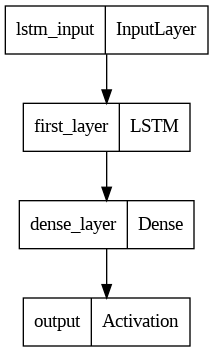

In [ ]:
#tf.random.set_seed(20)
np.random.seed(420)

lstm_input = Input(shape=(backcandles, 23), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
#inputs = Dense(150, name='dense_layer1')(inputs)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('sigmoid', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
model.summary()
plot_model(model)

In [ ]:
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])
history= model.fit(x=X_train, y=y_train, batch_size=32, epochs=40, shuffle=True, validation_split = 0.2)

Epoch 1/40
47/47 [==============================] - 4s 42ms/step - loss: 0.2537 - accuracy: 0.4939 - val_loss: 0.2553 - val_accuracy: 0.4553
Epoch 2/40
47/47 [==============================] - 1s 31ms/step - loss: 0.2505 - accuracy: 0.5217 - val_loss: 0.2491 - val_accuracy: 0.5285
Epoch 3/40
47/47 [==============================] - 1s 26ms/step - loss: 0.2502 - accuracy: 0.5169 - val_loss: 0.2516 - val_accuracy: 0.4932
Epoch 4/40
47/47 [==============================] - 2s 47ms/step - loss: 0.2497 - accuracy: 0.5244 - val_loss: 0.2515 - val_accuracy: 0.4959
Epoch 5/40
47/47 [==============================] - 3s 70ms/step - loss: 0.2500 - accuracy: 0.5122 - val_loss: 0.2498 - val_accuracy: 0.4824
Epoch 6/40
47/47 [==============================] - 3s 56ms/step - loss: 0.2497 - accuracy: 0.5210 - val_loss: 0.2483 - val_accuracy: 0.5610
Epoch 7/40
47/47 [==============================] - 3s 57ms/step - loss: 0.2494 - accuracy: 0.5224 - val_loss: 0.2509 - val_accuracy: 0.4851
Epoch 8/40
47

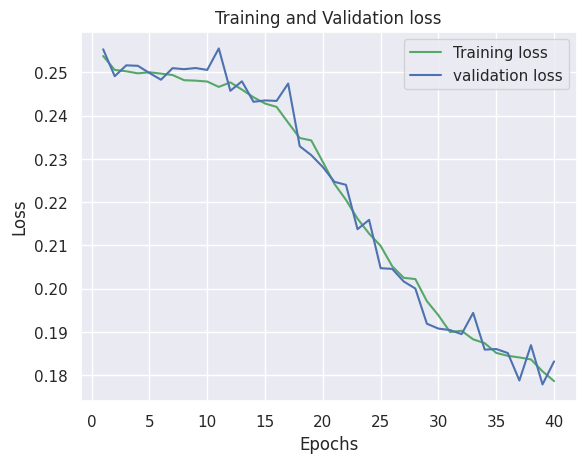

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

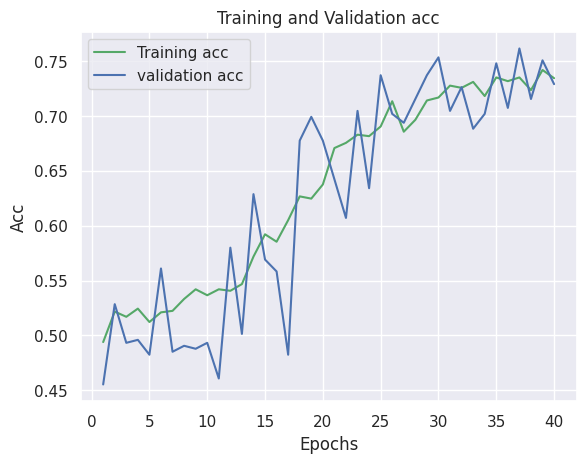

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,41)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.plot(epochs, acc_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred=np.where(y_pred > 0.50, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

15/15 [==============================] - 1s 10ms/step
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [1.]
[1] [1.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [1.]


In [ ]:
print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))

MNB_f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, y_pred)*100),2)

print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

              precision    recall  f1-score   support

         0.0     0.6918    0.8245    0.7523       245
         1.0     0.7471    0.5853    0.6563       217

    accuracy                         0.7121       462
   macro avg     0.7194    0.7049    0.7043       462
weighted avg     0.7177    0.7121    0.7072       462

[[202  43]
 [ 90 127]]
Accuracy :  71.21  %
f1_score :  0.707


Text(109.44999999999997, 0.5, 'Actual label')

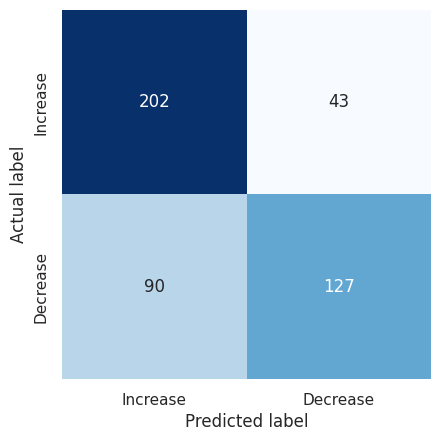

In [ ]:
mat = confusion_matrix(y_test, y_pred)
labels = ['Increase', 'Decrease']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

## Getting output from the last LSTM layer

In [ ]:
model_out = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('output').output)
model_out = model_out(X_test)

In [ ]:
print(model_out)

tf.Tensor(
[[0.56879926 0.566391  ]
 [0.45716256 0.45456567]
 [0.53556436 0.5309783 ]
 ...
 [0.47620422 0.48014638]
 [0.36317736 0.36625135]
 [0.5808375  0.5867518 ]], shape=(948, 2), dtype=float32)


## (Not use) Predictions with SoftMax

In [ ]:
prediction = model(X_test)
prediction = tf.nn.softmax(prediction)
label = np.argmax(prediction, axis = 1)
predict7 = prediction[7]
print(predict7)
label7 = np.argmax(predict7)
print(label7)

tf.Tensor([0.99999994], shape=(1,), dtype=float32)
0


In [ ]:
prediction2= model.predict(X_test)
prediction2 = tf.nn.softmax(prediction2)
predict0_7 = prediction2[0:7]
print(predict0_7.shape)
label0_7= np.argmax(predict0_7, axis =1)
print(label0_7)

15/15 [==============================] - 0s 9ms/step
(7, 1)
[0 0 0 0 0 0 0]


In [ ]:
print(predict05)
print(predict0_5)

tf.Tensor(
[[0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]], shape=(5, 1), dtype=float32)
tf.Tensor(
[[0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]], shape=(5, 1), dtype=float32)


In [ ]:
for i in range(200):
    print(label[i], y_test[i])

0 [1.]
0 [0.]
0 [1.]
0 [1.]
0 [1.]
0 [1.]
0 [1.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [1.]
0 [1.]
0 [1.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [0.]
0 [0.]
0 [1.]
0 [1.]
0 [1.]
0 [0.]
0 [0.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [1.]
0 [1.]
0 [0.]
0 [1.]
0 [1.]
0 [0.]
0 [1.]
0 [0.]
0 [1.]
0 [1.]
0 [1.]
0 [0.]
0 [0.]
0 [1.]
0 [0.]
0 [1.]
0 [0.]
0 [1.]
0 [0.]
0 [1.]
0 [1.]
0 [0.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [1.]
0 [1.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [1.]
0 [1.]
0 [1.]
0 [0.]
0 [1.]
0 [0.]
0 [1.]
0 [1.]
0 [0.]
0 [1.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [0.]
0 [1.]
0 [1.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [1.]
0 [1.]
0 [0.]
0 [0.]
0 [0.]
0 [1.]
0 [1.]
0 [0.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [0.]
0 [0.]
0 [1.]
0 [1.]
0 [0.]
0 [0.]
0 [1.]
0 [1.]
0 [0.]
0 [0.]
0 [1.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [1.]
0 [0.]
0 [1.]
0 [1.]
0 [1.]
0 [1.]
0 [1.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [0.]
0 [0.]
0 [0.]
0 [0.]
0 [1.]
0 [0.]
0 [1.]
0 [0.]
0 [0.]
0 [0.]
0 [0.]
0 [1.]

In [ ]:
print(classification_report(y_test, label))
print(confusion_matrix(y_test, label))

MNB_f1 = round(f1_score(y_test, label, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, label)*100),2)

print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69       244
         1.0       0.00      0.00      0.00       218

    accuracy                           0.53       462
   macro avg       0.26      0.50      0.35       462
weighted avg       0.28      0.53      0.37       462

[[244   0]
 [218   0]]
Accuracy :  52.81  %
f1_score :  0.365


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
